In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("sbdb_query_results.csv")
df.head()

Saving sbdb_query_results.csv to sbdb_query_results.csv


,spkid,full_name,H,diameter,albedo,e,a,q,i,ad,...,n_del_obs_used,n_dop_obs_used,per_y,moid,class,om,w,data_arc,condition_code,pha
0,20000433,433 Eros (A898 PA),10.38,16.840,0.250,0.2228,1.458,1.133,10.83,1.78,...,4.0,2.0,1.76,0.1480,AMO,304.27,178.93,46582.0,0.0,N
1,20000719,719 Albert (A911 TB),15.59,NaN,NaN,0.5466,2.637,1.195,11.57,4.08,...,NaN,NaN,4.28,0.2010,AMO,183.86,156.19,41775.0,0.0,N
2,20000887,887 Alinda (A918 AA),13.81,4.200,0.310,0.5712,2.474,1.061,9.40,3.89,...,16.0,0.0,3.89,0.0797,AMO,110.41,350.53,39281.0,0.0,N
3,20001036,1036 Ganymed (A924 UB),9.18,37.675,0.238,0.5332,2.665,1.244,26.68,4.09,...,0.0,1.0,4.35,0.3430,AMO,215.44,132.50,37015.0,0.0,N
4,20001221,1221 Amor (1932 EA1),17.37,1.000,NaN,0.4346,1.920,1.085,11.87,2.75,...,NaN,NaN,2.66,0.1080,AMO,171.24,26.76,33947.0,0.0,N


In [4]:
df.columns = df.columns.str.strip().str.lower()
#STEP 4 — Keep Only Required Columns
df = df[['h','diameter','albedo','e','a','i','q','ad','moid','pha']]
df.columns = [
    'absolute_magnitude',
    'diameter_km',
    'albedo',
    'eccentricity',
    'semi_major_axis',
    'inclination',
    'perihelion',
    'aphelion',
    'earth_moid',
    'is_hazardous'
]
numeric_cols = [
    'absolute_magnitude',
    'diameter_km',
    'albedo',
    'eccentricity',
    'semi_major_axis',
    'inclination',
    'perihelion',
    'aphelion',
    'earth_moid'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
df['is_hazardous'].value_counts()


,count
is_hazardous,
N,38333
Y,2538


In [5]:
df['is_hazardous'] = df['is_hazardous'].apply(
    lambda x: 1 if x == 'Y' else 0
)

df['is_hazardous'].value_counts()

,count
is_hazardous,
0,38464
1,2538


In [6]:
#STEP 2 — Handle Missing Diameter
ALBEDO_DEFAULT = 0.14

def estimate_diameter(row):
    albedo = row['albedo'] if not pd.isnull(row['albedo']) else ALBEDO_DEFAULT
    return (1329 / np.sqrt(albedo)) * (10 ** (-row['absolute_magnitude'] / 5))

df['diameter_km'] = df.apply(
    lambda row: estimate_diameter(row)
    if pd.isnull(row['diameter_km']) else row['diameter_km'],
    axis=1
)

In [7]:
#Fill Remaining Missing Values
df['albedo'].fillna(ALBEDO_DEFAULT, inplace=True)

df = df.dropna()
df.isnull().sum()

/tmp/ipython-input-531/2383041849.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['albedo'].fillna(ALBEDO_DEFAULT, inplace=True)


,0
absolute_magnitude,0
diameter_km,0
albedo,0
eccentricity,0
semi_major_axis,0
inclination,0
perihelion,0
aphelion,0
earth_moid,0
is_hazardous,0


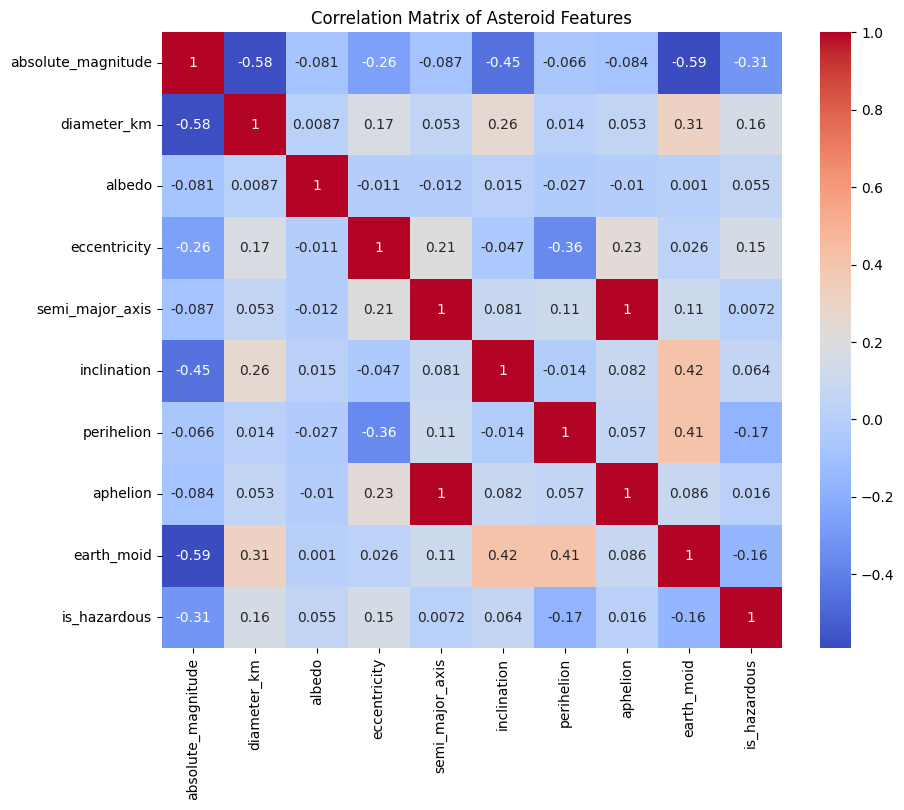

In [8]:
#Correlation Heatmap (Paper Figure)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Asteroid Features")
plt.show()

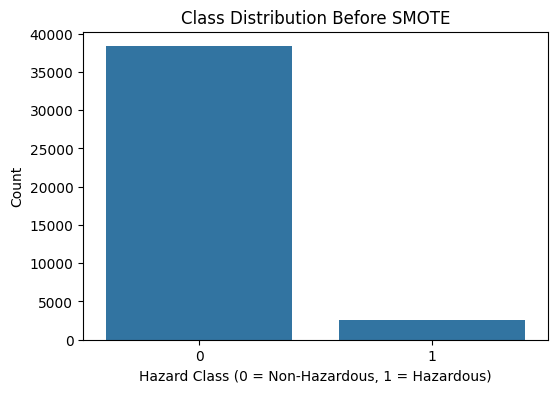

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
y = df['is_hazardous']          # Target variable
X = df.drop(columns=['is_hazardous'])
plt.figure(figsize=(6,4))
sns.countplot(x=y)

plt.title("Class Distribution Before SMOTE")
plt.xlabel("Hazard Class (0 = Non-Hazardous, 1 = Hazardous)")
plt.ylabel("Count")

plt.show()

In [10]:
#Define Features & Target
features = [
    'absolute_magnitude',
    'diameter_km',
    'albedo',
    'eccentricity',
    'semi_major_axis',
    'inclination',
    'perihelion',
    'aphelion',
    'earth_moid'
]

X = df[features]
y = df['is_hazardous']
#Train/Test Split (Stratified)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))
#Handle Imbalance Using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Train size: 32694
Test size: 8174
After SMOTE:
is_hazardous
0    30664
1    30664
Name: count, dtype: int64


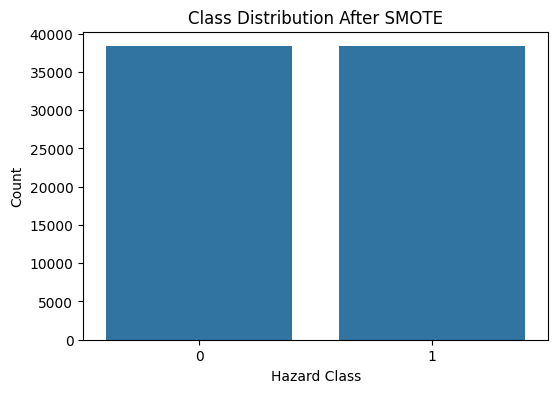

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
plt.figure(figsize=(6,4))
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Hazard Class")
plt.ylabel("Count")
plt.show()

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)


In [13]:
import numpy as np

np.save("X_train.npy", X_train_scaled)
np.save("X_test.npy", X_test_scaled)
np.save("y_train.npy", y_train_resampled)
np.save("y_test.npy", y_test)

print("Day 1 Completed Successfully 🚀")

Day 1 Completed Successfully 🚀


# **Dataset + EDA (Done)**

(1) Download NASA NEO dataset

(2)Clean missing values

(3)Perform EDA

(3)Visualize hazard distribution

(4)Feature selection

(5)Save clean dataset


# Multi-Model Benchmarking

In [14]:
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
feature_columns = [
    'absolute_magnitude',
    'diameter_km',
    'albedo',
    'eccentricity',
    'semi_major_axis',
    'inclination',
    'perihelion',
    'aphelion',
    'earth_moid'
]

X = df[feature_columns].values
y = df['is_hazardous'].values
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {
    "Logistic Regression": [],
    "Random Forest": [],
    "XGBoost": [],
    "Neural Network": []
}

for train_index, test_index in skf.split(X, y):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Scale for models that need it
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # -------------------
    # Logistic Regression
    # -------------------
    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    y_pred = lr.predict(X_test_scaled)
    y_prob = lr.predict_proba(X_test_scaled)[:,1]

    results["Logistic Regression"].append([
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)
    ])

    # -------------------
    # Random Forest
    # -------------------
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:,1]

    results["Random Forest"].append([
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)
    ])

    # -------------------
    # XGBoost
    # -------------------
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)[:,1]

    results["XGBoost"].append([
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)
    ])

    # -------------------
    # Neural Network
    # -------------------
    nn = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    nn.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

    nn.fit(X_train_scaled, y_train,
           epochs=20,
           batch_size=32,
           verbose=0)

    y_prob = nn.predict(X_test_scaled).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    results["Neural Network"].append([
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        roc_auc_score(y_test, y_prob),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)
    ])
    final_results = {}

for model_name in results:
    metrics = np.array(results[model_name])

    final_results[model_name] = {
        "Accuracy_mean": metrics[:,0].mean(),
        "Accuracy_std": metrics[:,0].std(),
        "F1_mean": metrics[:,1].mean(),
        "ROC_AUC_mean": metrics[:,2].mean(),
        "Precision_mean": metrics[:,3].mean(),
        "Recall_mean": metrics[:,4].mean()
    }

pd.DataFrame(final_results).T

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [04:06:09] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [04:06:51] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [04:07:33] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [04:08:16] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [04:08:58] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


,Accuracy_mean,Accuracy_std,F1_mean,ROC_AUC_mean,Precision_mean,Recall_mean
Logistic Regression,0.977024,0.002280,0.807870,0.991829,0.840762,0.777779
Random Forest,0.998679,0.000504,0.989337,0.998681,0.990942,0.987788
XGBoost,0.998214,0.000539,0.985582,0.999501,0.988186,0.983057
Neural Network,0.996892,0.000911,0.975023,0.999777,0.973785,0.976357


256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


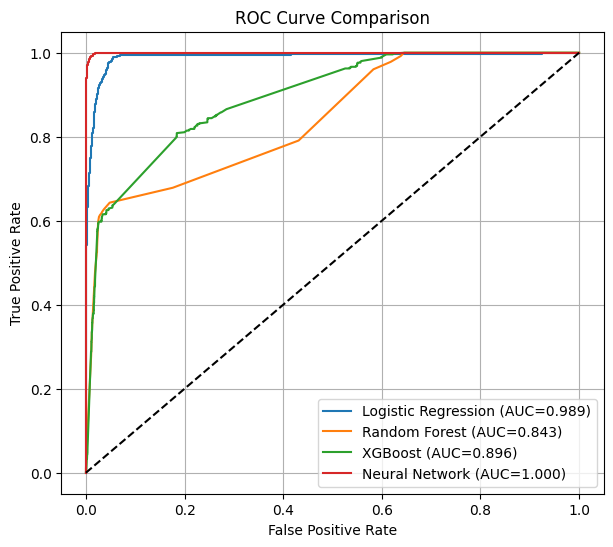

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probability predictions (USE YOUR REAL MODEL NAMES)
lr_probs = lr.predict_proba(X_test_scaled)[:,1]
rf_probs = rf.predict_proba(X_test_scaled)[:,1]
xgb_probs = xgb_model.predict_proba(X_test_scaled)[:,1]

# Neural Network probability output
nn_probs = nn.predict(X_test_scaled).ravel()

# ROC calculations
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

# AUC scores
lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)
nn_auc = auc(nn_fpr, nn_tpr)

# Plot
plt.figure(figsize=(7,6))

plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC={lr_auc:.3f})")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC={rf_auc:.3f})")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC={xgb_auc:.3f})")
plt.plot(nn_fpr, nn_tpr, label=f"Neural Network (AUC={nn_auc:.3f})")

plt.plot([0,1],[0,1],'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")

plt.legend()
plt.grid()

plt.savefig("Figure6_ROC_Curves.png", dpi=300, bbox_inches="tight")

plt.show()

In [16]:
%who

ALBEDO_DEFAULT	 Dense	 Dropout	 LogisticRegression	 RandomForestClassifier	 SMOTE	 Sequential	 StandardScaler	 StratifiedKFold	 
X	 X_resampled	 X_test	 X_test_scaled	 X_train	 X_train_resampled	 X_train_scaled	 accuracy_score	 auc	 
df	 estimate_diameter	 f1_score	 feature_columns	 features	 files	 final_results	 lr	 lr_auc	 
lr_fpr	 lr_probs	 lr_tpr	 metrics	 model_name	 nn	 nn_auc	 nn_fpr	 nn_probs	 
nn_tpr	 np	 numeric_cols	 pd	 plt	 precision_score	 recall_score	 results	 rf	 
rf_auc	 rf_fpr	 rf_probs	 rf_tpr	 roc_auc_score	 roc_curve	 scaler	 skf	 smote	 
sns	 test_index	 tf	 train_index	 train_test_split	 uploaded	 xgb	 xgb_auc	 xgb_fpr	 
xgb_model	 xgb_probs	 xgb_tpr	 y	 y_pred	 y_prob	 y_resampled	 y_test	 y_train	 
y_train_resampled	 


# using Random forest as it came out to be best for our model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7666
           1       0.99      0.99      0.99       507

    accuracy                           1.00      8173
   macro avg       0.99      0.99      0.99      8173
weighted avg       1.00      1.00      1.00      8173

ROC-AUC: 0.9998646653606618
              Feature  Importance
0  absolute_magnitude    0.329758
8          earth_moid    0.288168
1         diameter_km    0.277660
6          perihelion    0.073348
3        eccentricity    0.013170
5         inclination    0.007982
4     semi_major_axis    0.004070
7            aphelion    0.003486
2              albedo    0.002357


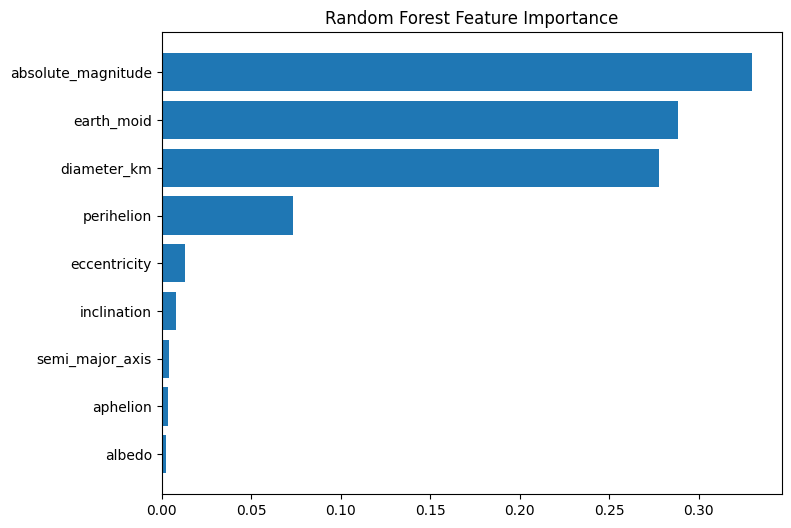

['scaler.pkl']

In [17]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Final model
rf_final = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf_final.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score

y_pred = rf_final.predict(X_test)
y_prob = rf_final.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
import pandas as pd
import matplotlib.pyplot as plt

feature_names = [
    'absolute_magnitude',
    'diameter_km',
    'albedo',
    'eccentricity',
    'semi_major_axis',
    'inclination',
    'perihelion',
    'aphelion',
    'earth_moid'
]

importance = rf_final.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feat_imp)

plt.figure(figsize=(8,6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance")
plt.show()

joblib.dump(rf_final, "rf_hazard_model.pkl")
joblib.dump(scaler, "scaler.pkl")

# SHAP (explaination)

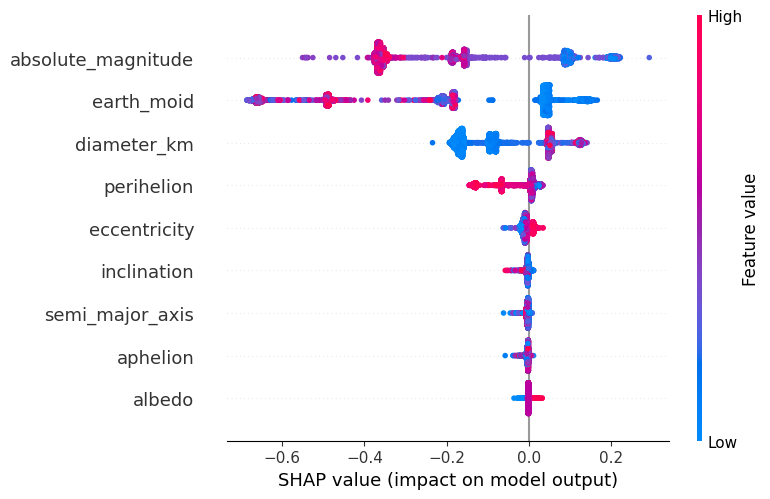

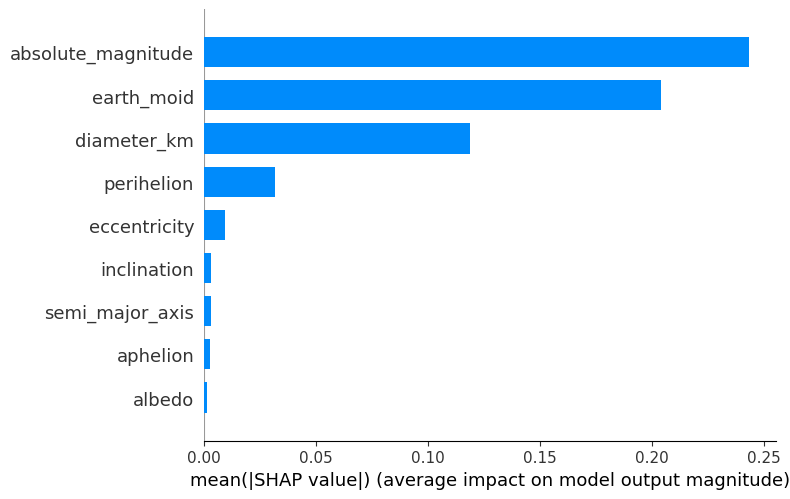

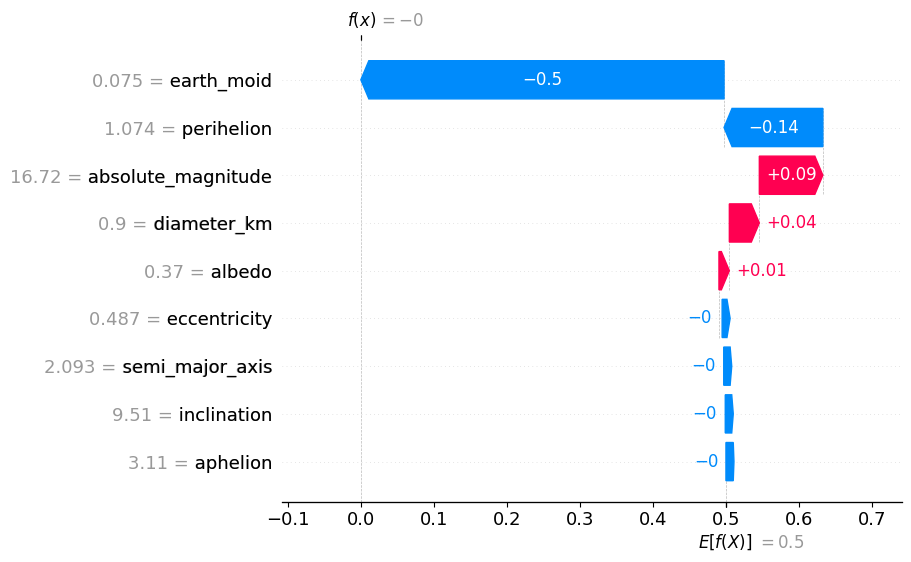

In [18]:
import shap

# Create explainer
explainer = shap.TreeExplainer(rf_final)

# NEW API call
shap_values = explainer(X_test)

# Extract SHAP values for hazardous class (class index 1)
shap_class1 = shap_values.values[:, :, 1]

# -------- GLOBAL IMPORTANCE (Beeswarm) --------
shap.summary_plot(
    shap_class1,
    X_test,
    feature_names=feature_names
)

# -------- GLOBAL BAR PLOT --------
shap.summary_plot(
    shap_class1,
    X_test,
    feature_names=feature_names,
    plot_type="bar"
)

# -------- SINGLE ASTEROID EXPLANATION --------
sample_index = 10

shap.plots.waterfall(
    shap.Explanation(
        values=shap_class1[sample_index],
        base_values=shap_values.base_values[sample_index, 1],
        data=X_test[sample_index],
        feature_names=feature_names
    )
)

# Hazardous

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Define feature columns (must match training)
feature_columns = [
    'absolute_magnitude',
    'diameter_km',
    'albedo',
    'eccentricity',
    'semi_major_axis',
    'inclination',
    'perihelion',
    'aphelion',
    'earth_moid'
]

X = df[feature_columns]
y = df['is_hazardous']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Final Random Forest model
rf_final = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

rf_final.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

# Energy Computation (Physics Model)

In [20]:
import math

def compute_impact_energy(diameter_km, velocity_kms=20, density=3000):
    diameter_m = diameter_km * 1000
    radius = diameter_m / 2

    volume = (4/3) * math.pi * radius**3
    mass = density * volume

    velocity_ms = velocity_kms * 1000
    energy_joules = 0.5 * mass * velocity_ms**2

    megatons = energy_joules / 4.184e15
    return megatons
def multi_hazard_model(energy_mt, surface_type, impact_angle):

    angle_factor = math.sin(math.radians(impact_angle))

    blast_radius = (energy_mt ** (1/3)) * 1.8 * angle_factor

    if surface_type == 1:  # land
        thermal_radius = blast_radius * 1.3
    else:
        thermal_radius = blast_radius * 0.7

    temp_drop = min(8, math.log10(energy_mt + 1) * 1.2)

    if surface_type == 0:
        tsunami_height = min(500, energy_mt ** 0.25 * 3)
    else:
        tsunami_height = 0

    return {
        "blast_radius_km": round(blast_radius, 2),
        "thermal_radius_km": round(thermal_radius, 2),
        "estimated_temp_drop_C": round(temp_drop, 2),
        "tsunami_height_m": round(tsunami_height, 2)
    }
import numpy as np

def full_asteroid_assessment(
    orbital_features,
    diameter_km,
    surface_type,
    impact_angle
):

    # Convert to DataFrame (important for correct feature order)
    X_input = np.array(orbital_features).reshape(1, -1)

    # Predict hazard
    hazard_prob = rf_final.predict_proba(X_input)[0][1]
    hazard_class = rf_final.predict(X_input)[0]

    # Compute energy
    energy_mt = compute_impact_energy(diameter_km)

    # Environmental effects
    hazard_effects = multi_hazard_model(
        energy_mt,
        surface_type,
        impact_angle
    )

    return {
        "hazard_probability": round(float(hazard_prob), 6),
        "hazardous": bool(hazard_class),
        "impact_energy_megatons": round(float(energy_mt), 2),
        **hazard_effects
    }
sample = X.iloc[10].values.tolist()

result = full_asteroid_assessment(
    orbital_features=sample,
    diameter_km=0.8,
    surface_type=1,
    impact_angle=45
)

print(result)

{'hazard_probability': 0.996667, 'hazardous': True, 'impact_energy_megatons': 38443.96, 'blast_radius_km': 42.96, 'thermal_radius_km': 55.84, 'estimated_temp_drop_C': 5.5, 'tsunami_height_m': 0}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# SOCIETAL RISK SCORING

In [21]:
def societal_risk_score(
    hazard_prob,
    energy_mt,
    blast_radius,
    temp_drop,
    population_density,
    economic_exposure
):

    # Normalize energy (log scale)
    energy_score = min(1, math.log10(energy_mt + 1) / 8)

    # Normalize blast impact
    blast_score = min(1, blast_radius / 500)

    # Normalize climate damage
    climate_score = min(1, temp_drop / 8)

    # Normalize socio factors
    pop_score = min(1, population_density / 10000)
    econ_score = min(1, economic_exposure / 1e12)

    # Weighted scoring model
    risk = (
        0.30 * hazard_prob +
        0.20 * energy_score +
        0.15 * blast_score +
        0.10 * climate_score +
        0.15 * pop_score +
        0.10 * econ_score
    )

    return round(risk * 100, 2)
def full_asteroid_assessment(
    orbital_features,
    diameter_km,
    surface_type,
    impact_angle,
    population_density,
    economic_exposure
):

    X_input = np.array(orbital_features).reshape(1, -1)

    hazard_prob = rf_final.predict_proba(X_input)[0][1]
    hazard_class = rf_final.predict(X_input)[0]

    energy_mt = compute_impact_energy(diameter_km)

    hazard_effects = multi_hazard_model(
        energy_mt,
        surface_type,
        impact_angle
    )

    # Compute societal risk
    final_risk = societal_risk_score(
        hazard_prob,
        energy_mt,
        hazard_effects["blast_radius_km"],
        hazard_effects["estimated_temp_drop_C"],
        population_density,
        economic_exposure
    )

    return {
        "hazard_probability": round(float(hazard_prob), 6),
        "hazardous": bool(hazard_class),
        "impact_energy_megatons": round(float(energy_mt), 2),
        **hazard_effects,
        "final_risk_score_0_100": final_risk
    }
sample = X.iloc[10].values.tolist()

result = full_asteroid_assessment(
    orbital_features=sample,
    diameter_km=0.8,
    surface_type=1,
    impact_angle=45,
    population_density=5000,      # mock value
    economic_exposure=2e11        # mock value
)

print(result)


{'hazard_probability': 0.996667, 'hazardous': True, 'impact_energy_megatons': 38443.96, 'blast_radius_km': 42.96, 'thermal_radius_km': 55.84, 'estimated_temp_drop_C': 5.5, 'tsunami_height_m': 0, 'final_risk_score_0_100': np.float64(59.03)}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# RESEARCH-GRADE VALIDATION SECTION

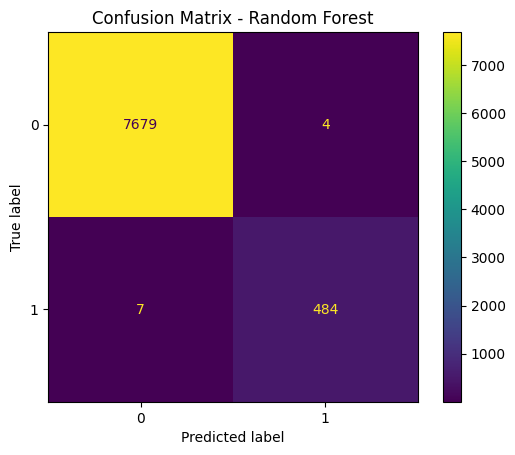

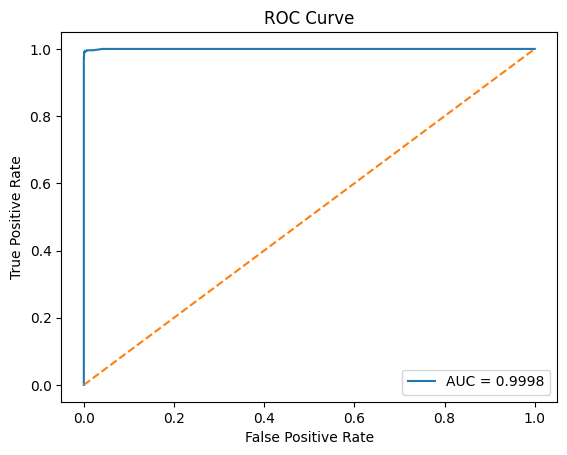

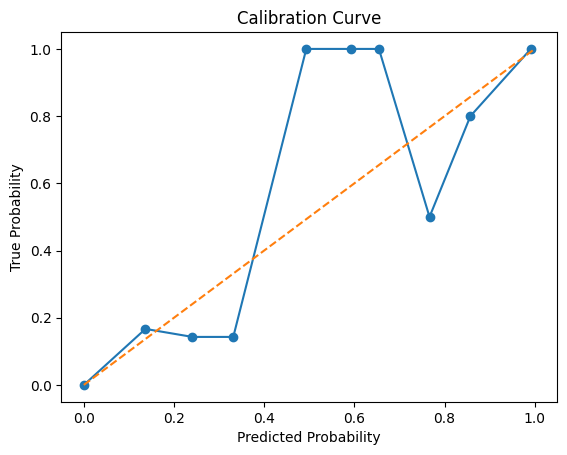

In [22]:
#CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, rf_final.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

#ROC Curve
from sklearn.metrics import roc_curve, auc

y_probs = rf_final.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#Calibration Curve
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.show()